# Analysis for USA

In [95]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
sns.set_palette("Set2")
palette = sns.color_palette("Set2")

import pycountry
import pycountry_convert as pc

import folium

from datetime import datetime

from locationHelper import LocationHelper
from preProcessingHelper import PreProcessRatings

from pandas.api.types import CategoricalDtype

from scipy.stats import norm, f_oneway, shapiro, kruskal
import random


np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
# helper functions
def get_rating_per_month(df: pd.DataFrame):
    months = np.sort(df["month"].dropna().unique())
    # print(months)
    all_months_vals = []
    for m in months:
        month_list = df[df["month"] == m]["rating"].values
        all_months_vals.append(month_list)
    return all_months_vals


def round_to_quarter(l: list):
    # rounds to the nearest quarter
    return np.rint(np.array(l) * 4) / 4

def get_year_groups(df: pd.DataFrame, n_groups: int):
    """
    generates new column "year_group" in the given dataframe
    returns: sorted year group categories
    """
    min_year, max_year = df["year"].min(), df["year"].max()
    while (max_year - min_year + 1) % n_groups != 0:
        max_year += 1
    all_years = np.arange(min_year, max_year+1)
    group_size = np.floor(len(all_years) / n_groups)
    year_groups = np.split(all_years, group_size)

    for yg in year_groups:
        indices = df[df["year"].isin(yg)].index
        df.loc[indices, "year_group"] = f'{yg.min()}-{yg.max()}'
    year_group_categories = np.sort(df["year_group"].unique()) # sorted categories
    cat_type = CategoricalDtype(categories=year_group_categories, ordered=True)
    df["year_group"] = df["year_group"].astype(cat_type)
    return year_group_categories

In [113]:
reviews_df = pd.read_csv("data/tims_data/beerAdvocateReviews.csv") # subset of ratings containing more fields
ratings_df = pd.read_csv("data/tims_data/beerAdvocateRatings.csv") 

# drop first years of data
n_groups = 5
year_group_categories = get_year_groups(reviews_df, n_groups)
get_year_groups(ratings_df, n_groups)

reviews_df = reviews_df[reviews_df["year"] > 2001]
ratings_df = ratings_df[ratings_df["year"] > 2001]

# only US
reviews_df_usa = reviews_df[reviews_df["country_code3"] == "USA"]
ratings_df_usa = ratings_df[ratings_df["country_code3"] == "USA"]



How does it look in the US, where we have the most data? (the amplitude for the countries on the northern hemisphere must be decreased by the ratings of the southern hemisphere.)

Text(0.5, 1.0, 'Avg rating in the US over the period 2001 - 2017 with 95% confidence interval, n=7303542')

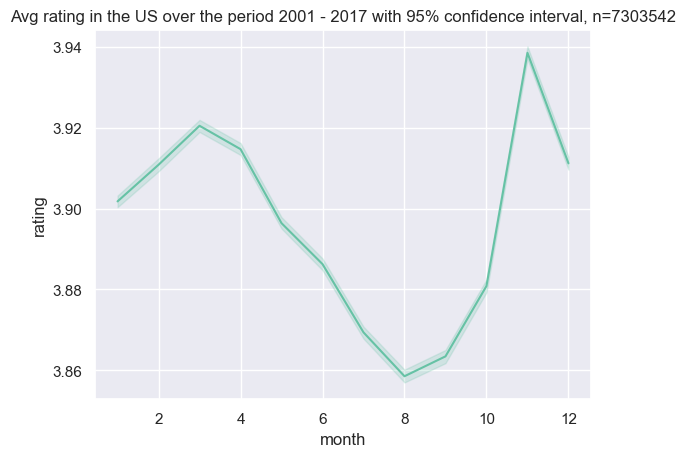

In [7]:
sns.lineplot(ratings_df_usa, x="month", y="rating", estimator="mean", errorbar=("ci", 95))
plt.title(f'Avg rating in the US over the period {ratings_df_usa["year"].min()} - {ratings_df_usa["year"].max()} with 95% confidence interval, n={ratings_df_usa.shape[0]}')

/var/folders/g9/6lh8d5yj335fzgmhtg8p866h0000gn/T/ipykernel_7813/1138512510.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ratings_df_usa, x="month", y="rating", palette=sns.color_palette("Set2"))
/var/folders/g9/6lh8d5yj335fzgmhtg8p866h0000gn/T/ipykernel_7813/1138512510.py:1: UserWarning: 
The palette list has fewer values (8) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(ratings_df_usa, x="month", y="rating", palette=sns.color_palette("Set2"))


<Axes: xlabel='month', ylabel='rating'>

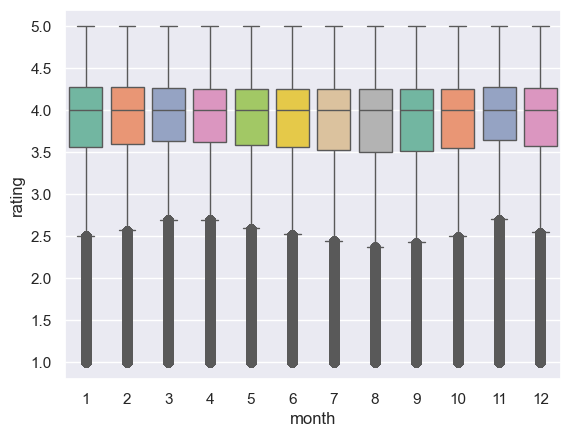

In [36]:
sns.boxplot(ratings_df_usa, x="month", y="rating", palette=sns.color_palette("Set2"))

<Axes: xlabel='month', ylabel='rating'>

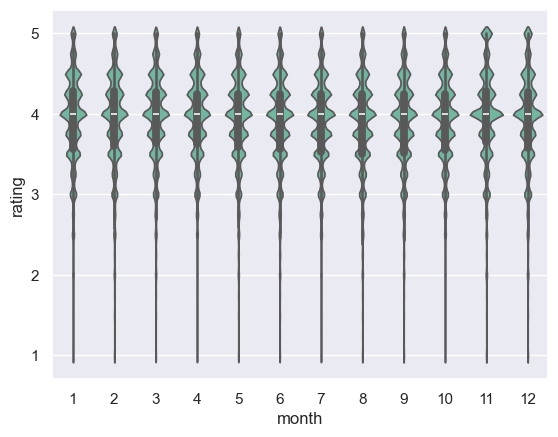

In [9]:
sns.violinplot(ratings_df_usa, x="month", y="rating")


/var/folders/g9/6lh8d5yj335fzgmhtg8p866h0000gn/T/ipykernel_7813/2424508365.py:1: UserWarning: 
The palette list has fewer values (8) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(ratings_df_usa.sample(int(ratings_df_usa.shape[0] * 0.0005)), x="month", y="rating", hue="month", jitter=0.3, legend=False, palette=sns.color_palette("Set2"))


<Axes: xlabel='month', ylabel='rating'>

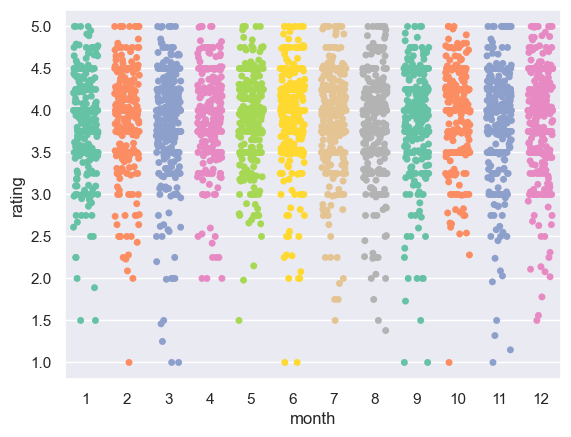

In [35]:
sns.stripplot(ratings_df_usa.sample(int(ratings_df_usa.shape[0] * 0.0005)), x="month", y="rating", hue="month", jitter=0.3, legend=False, palette=sns.color_palette("Set2"))

It looks as if the world doesn't rate the beers the same over the year! Why could that be the case? We want to see if it's statistically relevant! 


Our dependent variable is the rating of the beer and our indepenent variable is the month. We want to assess the differences between groups on a continuous measurement with only one independent variable and therefore choose the one-way ANOVA test. First we assess if the data meets the conditions for ANOVA.

$H_0:$ The means of the ratings for all the months are equal. 


$H_A:$ At least one mean of the ratings for a month is different from the rest.

/Users/klusertim/miniforge3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 638568.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=np.float64(0.9321067458711907), pvalue=np.float64(8.8461182031756e-136))

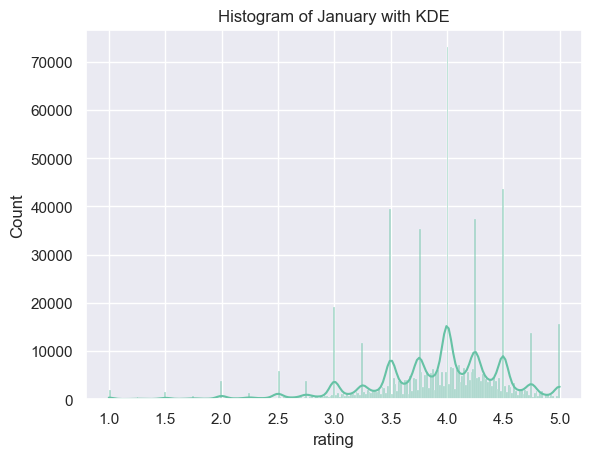

In [74]:
from scipy.stats import shapiro
all_months_vals = get_rating_per_month(ratings_df_usa)
h = sns.histplot(all_months_vals[0], kde=True)
h.set_title("Histogram of January with KDE")
h.set_xlabel("rating")
shapiro(all_months_vals[0])

We can already see in the plot that the data of our variables is most likely not normally distributed! Therefore we can't use the ANOVA test. 

We can also see that we have a lot more ratings at every number divisible by 0.25. Therefore we have to round it on the closest 0.25. Therefore the rating is now a discrete dependent variable instead of a continuous as before.

In [75]:
from scipy.stats import kruskal
kruskal(*all_months_vals)

KruskalResult(statistic=np.float64(14116.933735273924), pvalue=np.float64(0.0))

### for different year groups

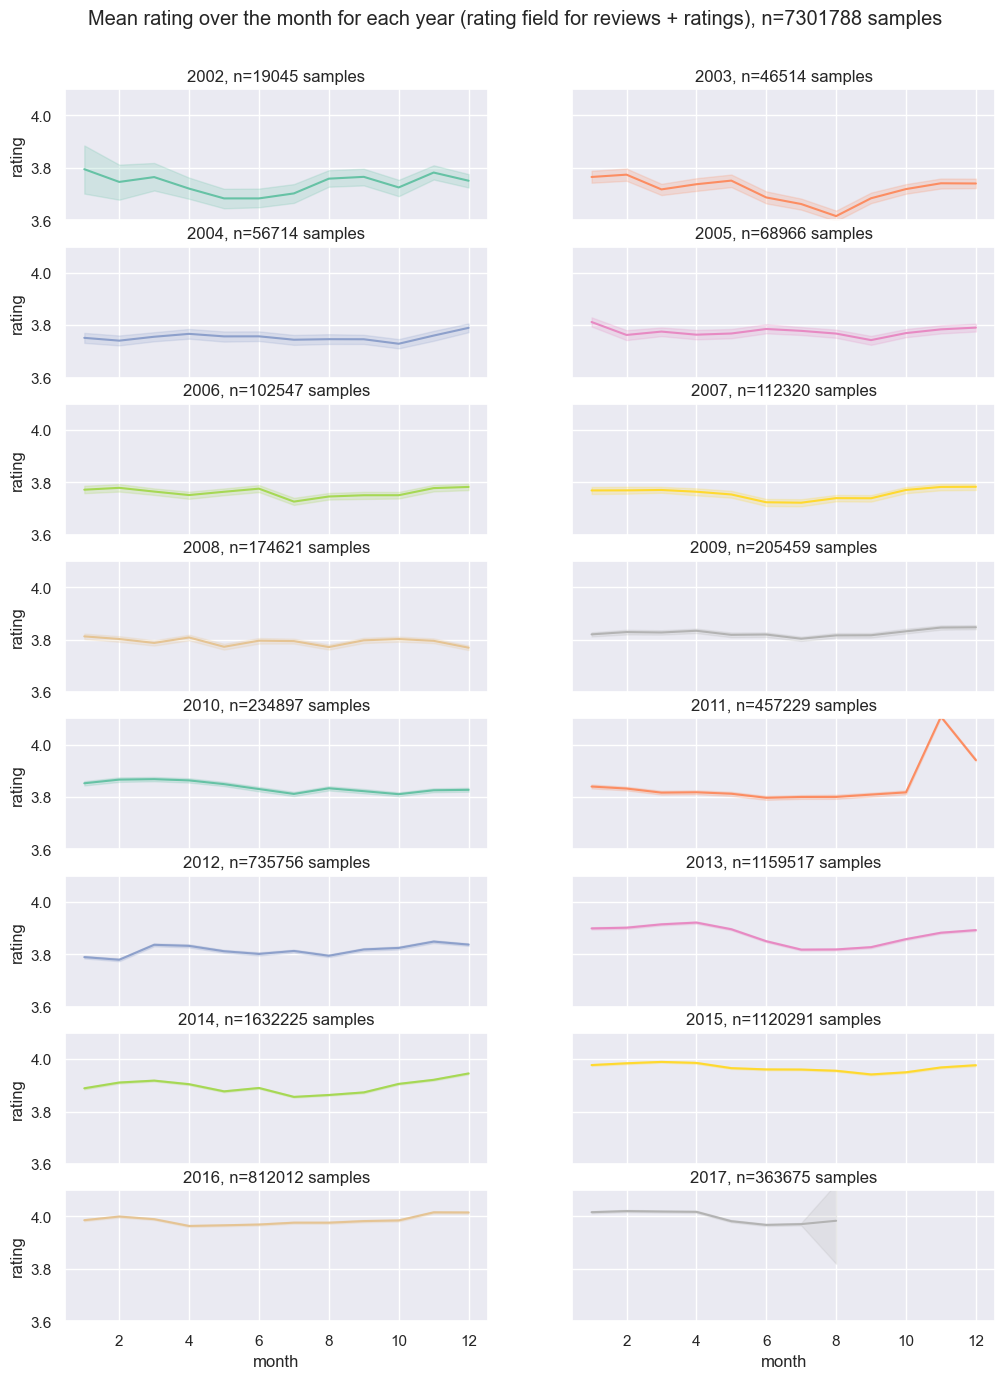

In [114]:
years = np.sort(ratings_df_usa["year"].dropna().unique())
fig, ax = plt.subplots(int(np.ceil(len(years)/2)), 2, figsize= (12, 16), sharex=True, sharey=True)
ax = ax.flatten()
fig.suptitle(f"Mean rating over the month for each year (rating field for reviews + ratings), n={ratings_df_usa.shape[0]} samples", y=0.93)
for i, year in enumerate(years):
    year_df = ratings_df_usa[ratings_df_usa["year"] == year]
    l = sns.lineplot(year_df, x = "month", y="rating", estimator="mean", errorbar=("ci", 95), ax=ax[i], color=palette[i%len(palette)])
    l.set_ylim(3.6, 4.1)
    l.set_title(f'{int(year)}, n={year_df.shape[0]} samples')

Q: what happened in 2011?

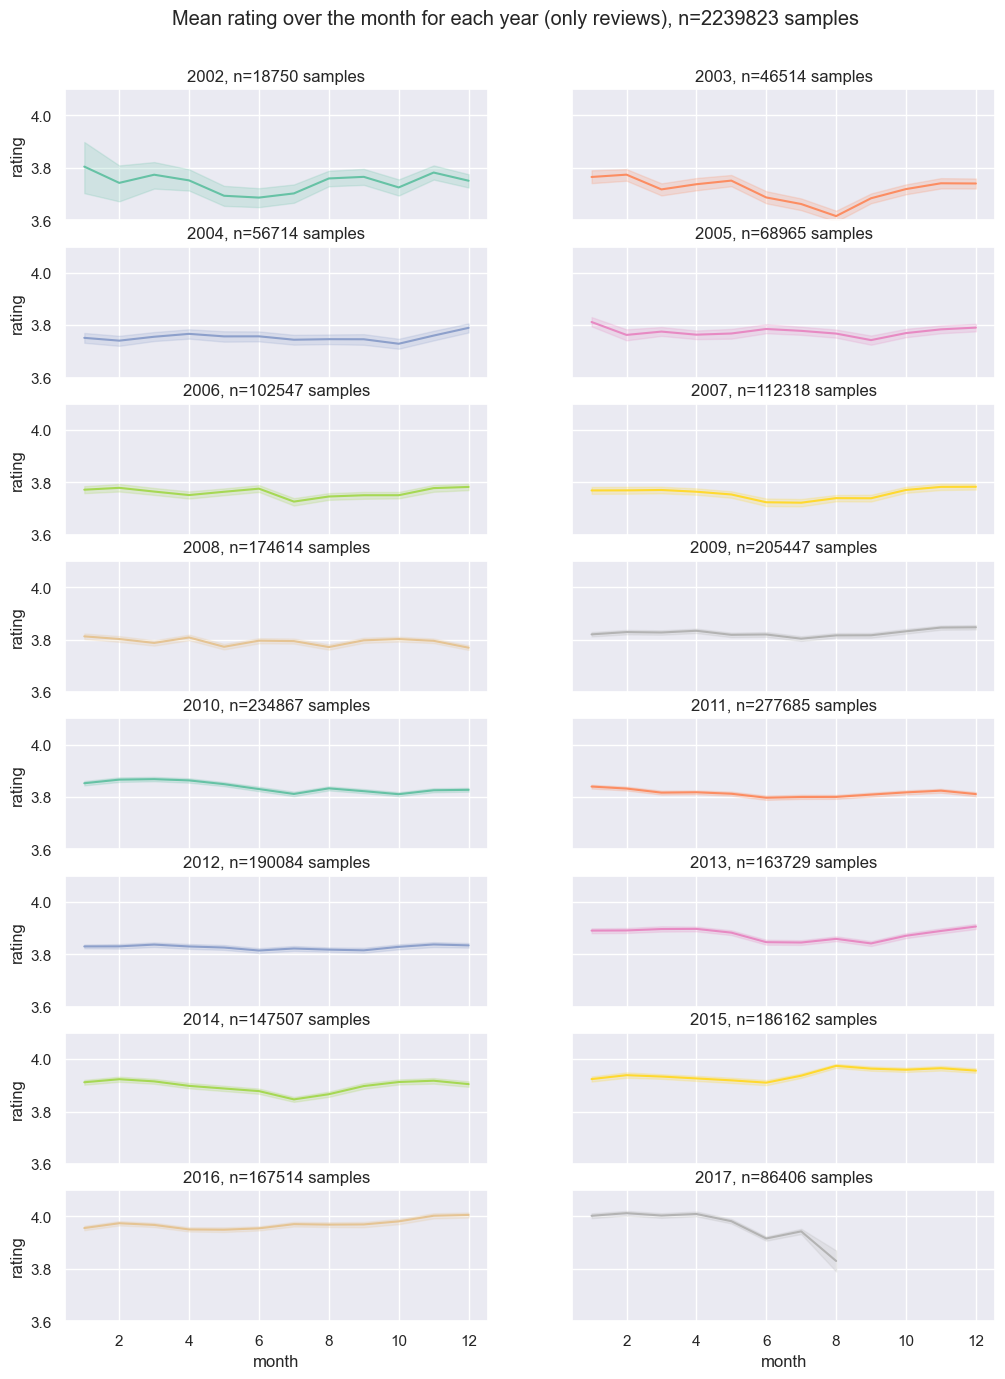

In [115]:
years = np.sort(reviews_df_usa["year"].dropna().unique())
fig, ax = plt.subplots(int(np.ceil(len(years)/2)), 2, figsize= (12, 16), sharex=True, sharey=True)
ax = ax.flatten()
fig.suptitle(f"Mean rating over the month for each year (only reviews), n={reviews_df_usa.shape[0]} samples", y=0.93)
for i, year in enumerate(years):
    year_df = reviews_df_usa[reviews_df_usa["year"] == year]
    l = sns.lineplot(year_df, x = "month", y="rating", estimator="mean", errorbar=("ci", 95), ax=ax[i], color=palette[i%len(palette)])
    l.set_ylim(3.6, 4.1)
    l.set_title(f'{int(year)}, n={year_df.shape[0]} samples')

1996-2000, n=0
2001-2005, n=192127
2006-2010, n=829793
2011-2015, n=965167
2016-2020, n=253920


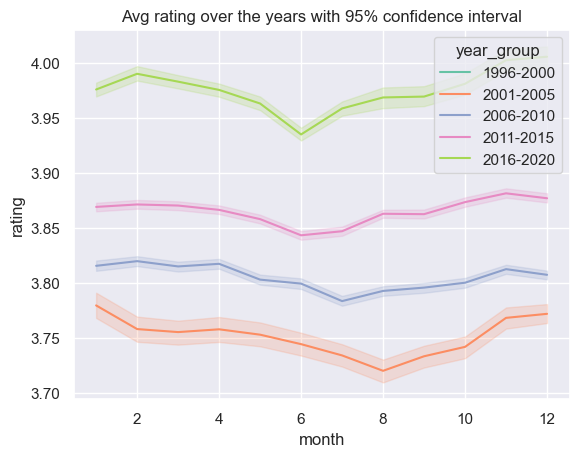

In [45]:
g = sns.lineplot(reviews_df_usa, x="month", y="rating", hue="year_group", estimator="mean", errorbar=("ci", 95))
legend = [yg.get_text() + f', n={reviews_df_usa[reviews_df_usa["year_group"] == yg.get_text()].shape[0]}' for yg in g.get_legend().texts]
plt.title(f'Avg rating over the years with 95% confidence interval')
# plt.legend(year_group_categories[1:])
print("\n".join([yg + f', n={reviews_df_usa[reviews_df_usa["year_group"] == yg].shape[0]}' for yg in year_group_categories]))


center rating for year group

In [ ]:
# center the data
means_yg = ratings_df_usa.groupby('year_group', observed=False)['rating'].transform('mean')
ratings_df_usa["centered_rating_yg"] = ratings_df_usa["rating"] - means_yg

/var/folders/g9/6lh8d5yj335fzgmhtg8p866h0000gn/T/ipykernel_7813/2337935791.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ratings_df_usa.loc["centered_rating_yg"] = ratings_df_usa["rating"] - means_yg
/var/folders/g9/6lh8d5yj335fzgmhtg8p866h0000gn/T/ipykernel_7813/2337935791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_usa.loc["centered_rating_yg"] = ratings_df_usa["rating"] - means_yg


In [52]:
ratings_df_usa.head(10)

,rating,country_name,country_code3,state,date_object,month,year,style,year_group,general_style,centered_rating_yg
0,2.88,United States,USA,Washington,2015-08-20 12:00:00,8.0,2015.0,Euro Pale Lager,2011-2015,lager,-1.015815
1,3.67,United States,USA,New York,2009-02-20 12:00:00,2.0,2009.0,English Pale Ale,2006-2010,ale,-0.135130
5,3.25,United States,USA,Kansas,2014-12-01 12:00:00,12.0,2014.0,English Pale Ale,2011-2015,ale,-0.645815
6,3.50,United States,USA,New Jersey,2014-05-29 12:00:00,5.0,2014.0,English Pale Ale,2011-2015,ale,-0.395815
7,3.50,United States,USA,North Carolina,2014-02-26 12:00:00,2.0,2014.0,English Pale Ale,2011-2015,ale,-0.395815
8,3.75,United States,USA,Oklahoma,2014-02-10 12:00:00,2.0,2014.0,English Pale Ale,2011-2015,ale,-0.145815
9,3.25,United States,USA,Kansas,2014-01-25 12:00:00,1.0,2014.0,English Pale Ale,2011-2015,ale,-0.645815
10,3.00,United States,USA,Pennsylvania,2013-10-03 12:00:00,10.0,2013.0,English Pale Ale,2011-2015,ale,-0.895815
11,3.00,United States,USA,California,2013-04-25 12:00:00,4.0,2013.0,English Pale Ale,2011-2015,ale,-0.895815
12,3.91,United States,USA,North Carolina,2013-02-13 12:00:00,2.0,2013.0,English Pale Ale,2011-2015,ale,0.014185


Text(0.5, 1.0, 'Centered avg rating over the years with 95% confidence interval')

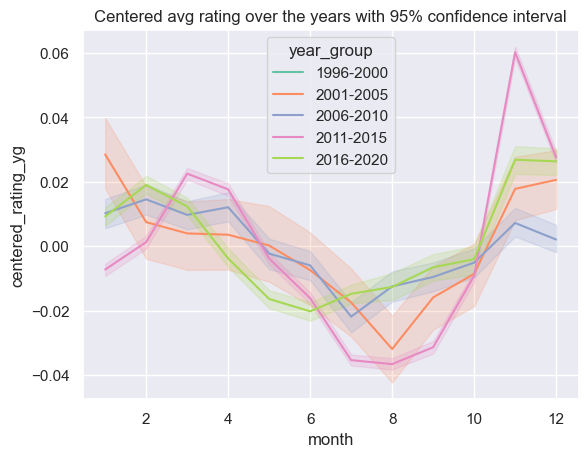

In [54]:
g = sns.lineplot(ratings_df_usa, x="month", y="centered_rating_yg", hue="year_group", estimator="mean", errorbar=("ci", 95))
legend = [yg.get_text() + f', n={ratings_df_usa[ratings_df_usa["year_group"] == yg.get_text()].shape[0]}' for yg in g.get_legend().texts]
plt.title(f'Centered avg rating over the years with 95% confidence interval')

### nr of ratings per month

<Axes: xlabel='month', ylabel='nr_ratings'>

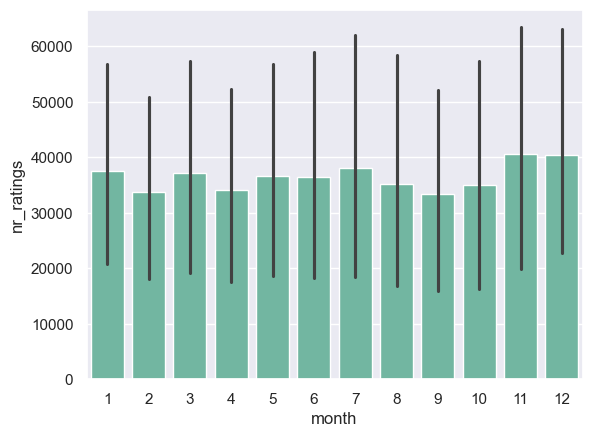

In [37]:
group_per_year = ratings_df_usa.groupby(["year", "month"]).aggregate(nr_ratings = ("rating", "count")).reset_index()
sns.barplot(group_per_year, x="month", y="nr_ratings", estimator="mean", errorbar="ci")
# group_per_year

### what do people like to review

In [38]:
all_types = ratings_df_usa["style"].unique().tolist()
print(len(all_types))
general_styles = ["lager", "ipa", "ale", "stout", "hybrid"]
types_dict = dict()
types = all_types.copy()

generalStyle = []
for style in ratings_df_usa["style"]:
    for mt in general_styles:
        gt = "other"
        if mt in style.lower():
            gt = mt
            break
    generalStyle.append(gt)

ratings_df_usa["general_style"] = generalStyle

104


/var/folders/g9/6lh8d5yj335fzgmhtg8p866h0000gn/T/ipykernel_7813/1664976991.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_usa["general_style"] = generalStyle


In [39]:
grouped_ratings = ratings_df_usa.groupby(["general_style", "month"]).aggregate(count=("rating", "count"))
grouped_ratings

count
general_style month        
ale           1      186098
              2      163459
              3      182574
              4      170311
              5      188505
              6      192190
              7      200068
              8      189095
              9      174700
              10     183244
              11     204383
              12     192438
ipa           1      133516
              2      131841
              3      151656
              4      143469
              5      151505
              6      153287
              7      161420
              8      141683
              9      118285
              10     122957
              11     133370
              12     125926
lager         1       31767
              2       28298
              3       29606
              4       28340
              5       32243
              6       33372
              7       36147
              8       33442
              9       27247
              10      25669
              11      29474
              12      30779
other         1      178869
              2      155134
              3      165479
              4      150139
              5      166629
              6      166647
              7      177423
              8      168301
              9      153867
              10     157343
              11     182059
              12     188297
stout         1      108318
              2       94468
              3      103183
              4       87080
              5       83016
              6       74324
              7       73654
              8       66746
              9       61108
              10      71920
              11      99161
              12     108013

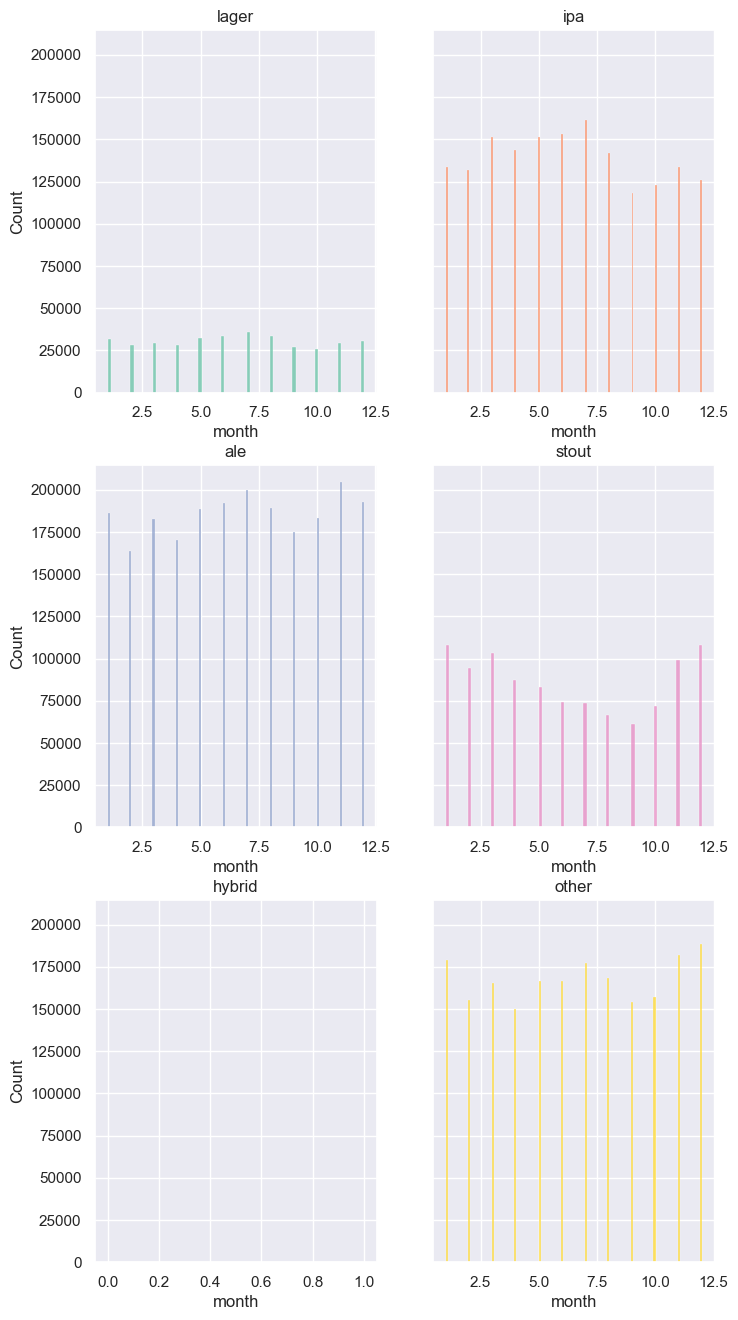

In [40]:

fig, ax = plt.subplots(3, 2, figsize= (8, 16), sharey=True, )
ax = ax.flatten()
# fig.tight_layout()
for i, gs in enumerate(general_styles + ["other"]):
    h = sns.histplot(ratings_df_usa[ratings_df_usa["general_style"] == gs], x="month" , color=sns.color_palette("Set2")[i], ax=ax[i])
    ax[i].set_title(gs)